In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fftpack import fft
from scipy.integrate import trapezoid

In [2]:
# -------------------------------
# 1. Load IMU Data
# -------------------------------
def load_imu_data(file_path):
    data = pd.read_csv(file_path)
    data["Time(s)"] = data["Time(ms)"] / 1000.0  # Convert time to seconds
    return data

# -------------------------------
# 2. Apply Butterworth Filter and High-pass Filter
# -------------------------------
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# -------------------------------
# 3. Compute Joint Angles (Knee, Hip, Ankle)
# -------------------------------
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.diff(time, prepend=time[0]))  # Numerical Integration
    return angle - np.mean(angle[:50]) + initial_angle  # Drift Correction

# -------------------------------
# 4. Detect Heel Strikes & Toe-Offs (Using GyroZ of Ankle)
# -------------------------------
def detect_gait_events(gyroZ, time, threshold=20):
    peaks, _ = find_peaks(gyroZ, height=threshold)  # Toe-off detection
    valleys, _ = find_peaks(-gyroZ, height=threshold)  # Heel-strike detection
    return time[peaks], time[valleys]

# -------------------------------
# 5. Compute Temporal Gait Parameters
# -------------------------------
def compute_temporal_parameters(heel_strikes):
    step_times = np.diff(heel_strikes)  # Time between heel strikes
    stride_times = step_times[::2]  # Stride time is every two steps
    cadence = 60 / np.mean(step_times)  # Steps per minute
    step_time_variability = np.std(step_times)  # Step variability
    return step_times, stride_times, cadence, step_time_variability

# -------------------------------
# 6. Compute Spatial Gait Parameters
# -------------------------------
def compute_step_length(accelY, time):
    velocity = np.cumsum(accelY * np.gradient(time))  # Integrate acceleration
    step_length = trapezoid(velocity, time) / len(time)  # Approximate distance per step
    return step_length

# -------------------------------
# 7. Compute Gait Symmetry & Interlimb Coordination
# -------------------------------
def compute_gait_symmetry(left_steps, right_steps):
    step_time_diff = np.abs(np.mean(left_steps) - np.mean(right_steps))
    stride_symmetry_index = (np.abs(np.mean(left_steps) - np.mean(right_steps)) / (np.mean(left_steps) + np.mean(right_steps))) * 100
    return step_time_diff, stride_symmetry_index

# -------------------------------
# 8. Load Data and Perform Analysis
# -------------------------------
left_thigh_file = "./Test_variant_with_force_sensor/test_fast_pace/LT.csv"
left_shank_file = "./Test_variant_with_force_sensor/test_fast_pace/LS.csv"
left_ankle_file = "./Test_variant_with_force_sensor/test_fast_pace/LA.csv"
right_thigh_file = "./Test_variant_with_force_sensor/test_fast_pace/RT.csv"
right_shank_file = "./Test_variant_with_force_sensor/test_fast_pace/RS.csv"
right_ankle_file = "./Test_variant_with_force_sensor/test_fast_pace/RA.csv"

In [3]:
left_thigh_data = load_imu_data(left_thigh_file)
left_shank_data = load_imu_data(left_shank_file)
left_ankle_data = load_imu_data(left_ankle_file)
right_thigh_data = load_imu_data(right_thigh_file)
right_shank_data = load_imu_data(right_shank_file)
right_ankle_data = load_imu_data(right_ankle_file)

In [4]:
fs = 100  

# Apply filtering
for data in [left_thigh_data, left_shank_data, left_ankle_data, right_thigh_data, right_shank_data, right_ankle_data]:
    data["GyroZ_filtered"] = butter_lowpass_filter(data["GyroZ"])
    data["GyroZ_filtered"] = high_pass_filter(data["GyroZ_filtered"], fs=fs)


In [5]:
# Compute Joint Angles
left_knee_angle = integrate_gyro(left_shank_data["GyroZ_filtered"], left_shank_data["Time(s)"]) - integrate_gyro(left_thigh_data["GyroZ_filtered"], left_thigh_data["Time(s)"])
right_knee_angle = integrate_gyro(right_thigh_data["GyroZ_filtered"], right_thigh_data["Time(s)"]) - integrate_gyro(right_shank_data["GyroZ_filtered"], right_shank_data["Time(s)"])


In [15]:
# Detect Gait Events
left_heel_strikes, left_toe_offs = detect_gait_events(left_ankle_data["GyroZ_filtered"], left_ankle_data["Time(s)"], threshold=90)
right_heel_strikes, right_toe_offs = detect_gait_events(right_ankle_data["GyroZ_filtered"], right_ankle_data["Time(s)"], threshold=105)

# Compute Gait Parameters
left_step_times, left_stride_times, left_cadence, left_variability = compute_temporal_parameters(left_heel_strikes)
right_step_times, right_stride_times, right_cadence, right_variability = compute_temporal_parameters(right_heel_strikes)

# Compute Symmetry
step_time_diff, stride_symmetry_index = compute_gait_symmetry(left_step_times, right_step_times)


In [16]:
print("Left Heel Strikes:", len(left_heel_strikes))
print("Right Heel Strikes:", len(right_heel_strikes))
print("Left Cadence:", left_cadence)
print("Right Cadence:", right_cadence)
print("Step Time Difference:", step_time_diff)
print("Stride Symmetry Index:", stride_symmetry_index)
print("Left Variability:", left_variability)
print("Right Variability:", right_variability)
print("Left Step Length:", compute_step_length(left_ankle_data["AccelY"], left_ankle_data["Time(s)"]))
print("Right Step Length:", compute_step_length(right_ankle_data["AccelY"], right_ankle_data["Time(s)"]))
print("Left Toe Offs:", len(left_toe_offs))
print("Right Toe Offs:", len(right_toe_offs))

Left Heel Strikes: 25
Right Heel Strikes: 24
Left Cadence: 73.5444330949949
Right Cadence: 65.47732017460619
Step Time Difference: 0.10051449275362323
Stride Symmetry Index: 5.802770236068292
Left Variability: 0.41460580341117104
Right Variability: 0.597345913091048
Left Step Length: 0.004816879108860742
Right Step Length: -0.003147038620675119
Left Toe Offs: 21
Right Toe Offs: 21


In [17]:
# -------------------------------
# Print Summary Results
# -------------------------------
print(f"Left Cadence: {left_cadence:.2f} steps/min")
print(f"Right Cadence: {right_cadence:.2f} steps/min")
print(f"Step Time Difference: {step_time_diff:.2f} s")
print(f"Stride Symmetry Index: {stride_symmetry_index:.2f}%")


Left Cadence: 73.54 steps/min
Right Cadence: 65.48 steps/min
Step Time Difference: 0.10 s
Stride Symmetry Index: 5.80%


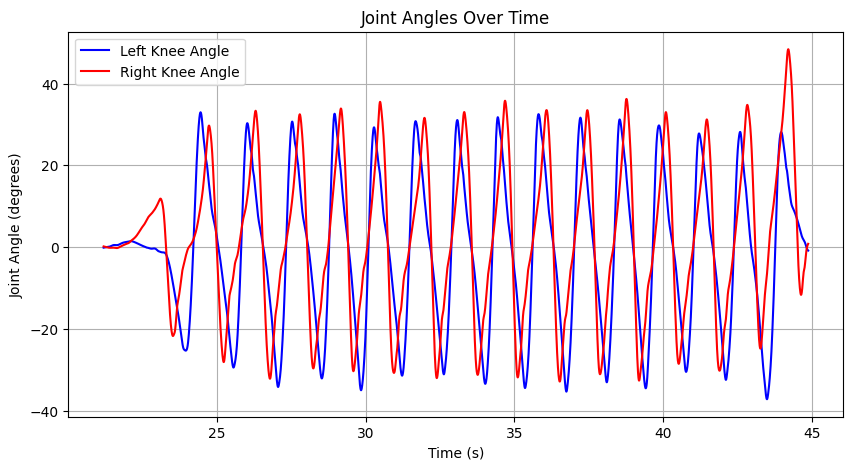

In [18]:
# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_thigh_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_thigh_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time")
plt.show(block=True)

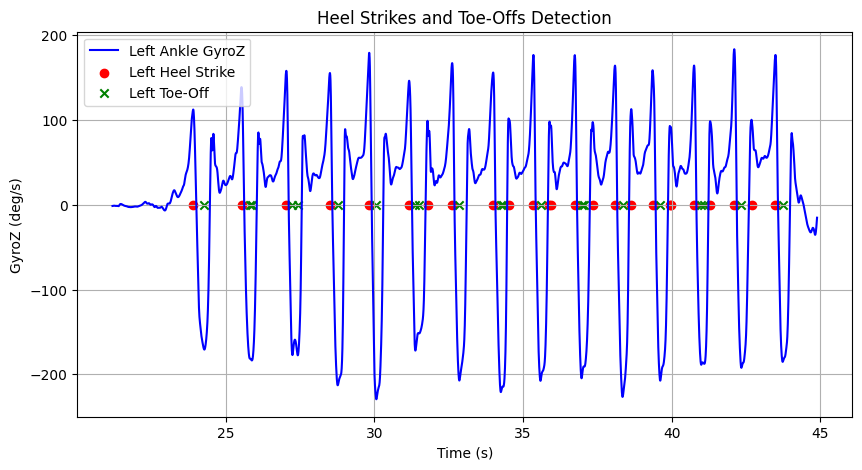

In [19]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for left ankle
plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Left Ankle GyroZ", color='blue')
plt.scatter(left_heel_strikes, [0] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection")
plt.show(block=True)

In [20]:
# Detect Gait Events
left_heel_strikes, left_toe_offs = detect_gait_events(left_ankle_data["GyroZ_filtered"], left_ankle_data["Time(s)"])
right_heel_strikes, right_toe_offs = detect_gait_events(right_ankle_data["GyroZ_filtered"], right_ankle_data["Time(s)"], threshold=3.5)

# Compute Gait Parameters
left_step_times, left_stride_times, left_cadence, left_variability = compute_temporal_parameters(left_heel_strikes)
right_step_times, right_stride_times, right_cadence, right_variability = compute_temporal_parameters(right_heel_strikes)

# Compute Symmetry
step_time_diff, stride_symmetry_index = compute_gait_symmetry(left_step_times, right_step_times)


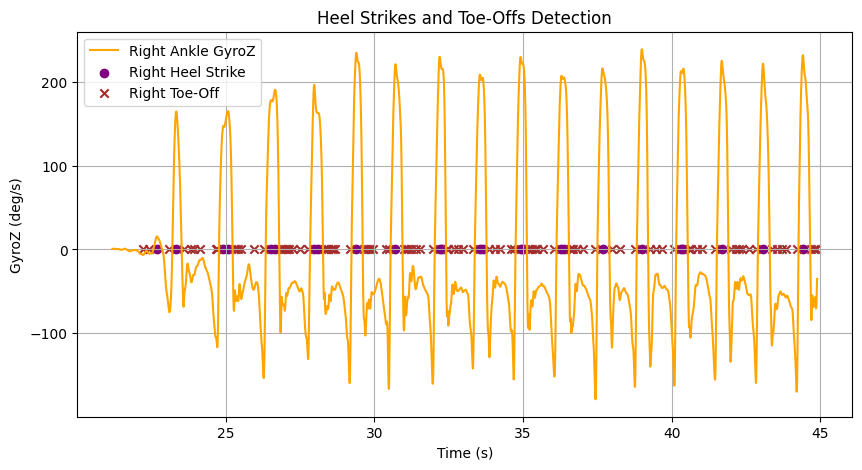

In [21]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for right ankle
plt.plot(right_ankle_data["Time(s)"], right_ankle_data["GyroZ_filtered"], label="Right Ankle GyroZ", color='orange')
plt.scatter(right_heel_strikes, [0] * len(right_heel_strikes), marker='o', color='purple', label="Right Heel Strike")
plt.scatter(right_toe_offs, [0] * len(right_toe_offs), marker='x', color='brown', label="Right Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection")
plt.show(block=True)

In [13]:
# plt.figure(figsize=(10, 5))
# plt.stem(freqs, fft_values, use_line_collection=True)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.title("Step Frequency Spectrum (FFT)")
# plt.grid()
# plt.show()

In [14]:
# # -------------------------------
# # Print Summary Results
# # -------------------------------
# print(f"Mean Step Time: {np.mean(step_times):.2f} s")
# print(f"Mean Stride Time: {np.mean(stride_times):.2f} s")
# print(f"Cadence: {cadence:.2f} steps/min")
# print(f"Estimated Step Length: {step_length}")
